In [108]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import allometric_equations as ae
import diameter_utils as du
import importlib
import joblib

## Loading and Scaling the Data

In [109]:
df = pd.read_csv('final_dataset_filtered.csv')

In [110]:
df['name'] = df['name'].apply(lambda x: x if x in ['Musacea','Guaba','Cacao','Mango'] else 'Otra variedad')

**Also need to remove the test data from my other model, so it is not leakage in this model** 

In [111]:
test_df = pd.read_csv('test_df_proper.csv')

In [112]:
test_ids = test_df['unique_id']

In [113]:
#remove rows with unique_id in test_ids
df = df[~df['unique_id'].isin(test_ids)]

In [114]:
#now that I have made sure there is no leakage, I can prepare this df for the model 
df_encoded = du.prepare_data(df, 'diameter')

In [120]:
X_scaled, y = du.split_data(df_encoded, scaler = False)

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Running the Model - Baseline (Random Forest)

In [122]:
#test the baseline model 
baseline = du.baseline_model(X_train)

/opt/homebrew/Caskroom/miniconda/base/envs/IRP_2/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [123]:
history = baseline.fit(X_train, y_train, epochs=100, validation_split=0.1, verbose=1)

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 127.0480 - val_loss: 39.5212
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 27.1279 - val_loss: 10.8801
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 10.5828 - val_loss: 8.7832
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 8.4607 - val_loss: 8.3881
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 8.2812 - val_loss: 8.4544
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 8.3639 - val_loss: 8.1506
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 8.1279 - val_loss: 8.2477
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 7.8037 - val_loss: 8.3899
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 7.9114 - val_loss: 8.5045
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 8.1217 - val_loss: 8.2944
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 7.8404 - val_loss: 8.2603
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━

In [124]:
y_pred = baseline.predict(X_test).flatten()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [125]:
du.mse_and_rmse(y_test, y_pred)

Mean Squared Error: 7.5882077668225
Root Mean Squared Error: 2.7546701738724546


(7.5882077668225, 2.7546701738724546)

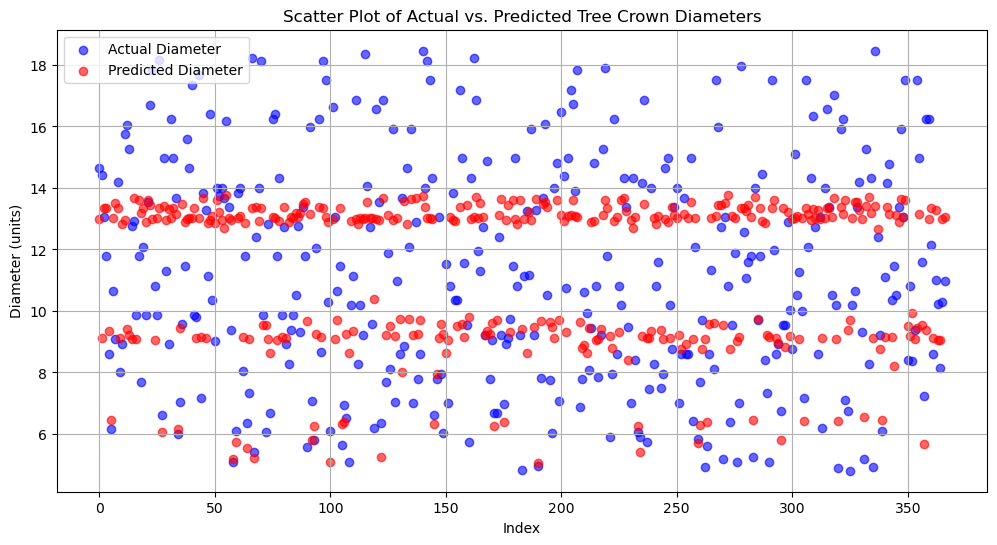

In [126]:
du.plot_results(y_test, y_pred)

In [127]:
du.compare(y_test, y_pred)

    Actual Diameter  Predicted Diameter  Difference (Absolute)
0         14.642221           12.983517               1.658704
1         14.419404            9.120853               5.298551
2         13.050675           13.356436               0.305761
3         11.777438           13.348068               1.570630
4          8.594347            9.346745               0.752398
5          6.174623            6.463981               0.289358
6         10.663356           13.029065               2.365709
7          9.103641           13.506883               4.403241
8         14.196588           13.348446               0.848142
9          8.021390            9.130256               1.108865
10         8.912656           12.822939               3.910283
11        15.756303           12.948582               2.807721
12        16.042781            9.415831               6.626950
13        15.278839            9.216622               6.062216
14        12.764197            9.092424               3

____

## SVM Regression

In [128]:
#further split the training data into training and validation sets; didn't need to do this for the baseline model because it took validation_split as an argument
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [129]:
best_params = du.SVR_model(X_train, y_train, X_val, y_val)

C=0.01, epsilon=0.01, gamma=scale, MSE=10.018605514451563
C=0.01, epsilon=0.01, gamma=auto, MSE=10.023933627165876
C=0.01, epsilon=0.01, gamma=0.1, MSE=10.100945810844792
C=0.01, epsilon=0.01, gamma=1, MSE=10.8475936259484
C=0.01, epsilon=0.1, gamma=scale, MSE=10.03324243491933
C=0.01, epsilon=0.1, gamma=auto, MSE=10.038734970071726
C=0.01, epsilon=0.1, gamma=0.1, MSE=10.100179861673347
C=0.01, epsilon=0.1, gamma=1, MSE=10.857215878164604
C=0.01, epsilon=0.5, gamma=scale, MSE=10.038944445993407
C=0.01, epsilon=0.5, gamma=auto, MSE=10.039570630978478
C=0.01, epsilon=0.5, gamma=0.1, MSE=10.11687164723239
C=0.01, epsilon=0.5, gamma=1, MSE=10.880261529048557
C=0.01, epsilon=1, gamma=scale, MSE=10.043837037005797
C=0.01, epsilon=1, gamma=auto, MSE=10.049139518915123
C=0.01, epsilon=1, gamma=0.1, MSE=10.097664147002751
C=0.01, epsilon=1, gamma=1, MSE=10.856197811950627
C=0.1, epsilon=0.01, gamma=scale, MSE=7.515052379687869
C=0.1, epsilon=0.01, gamma=auto, MSE=7.5130161558624735
C=0.1, epsil

In [130]:
# Initialize the SVR model with the best parameters
SVR_model = du.best_SVR(best_params)

# Train the model on the entire training dataset
SVR_model.fit(X_train, y_train)


SVR(C=0.1, epsilon=1, gamma=0.1)

In [131]:
y_pred_SVR = SVR_model.predict(X_test)

In [132]:
du.mse_and_rmse(y_test, y_pred_SVR)

Mean Squared Error: 7.629819163116265
Root Mean Squared Error: 2.7622127295189025


(7.629819163116265, 2.7622127295189025)

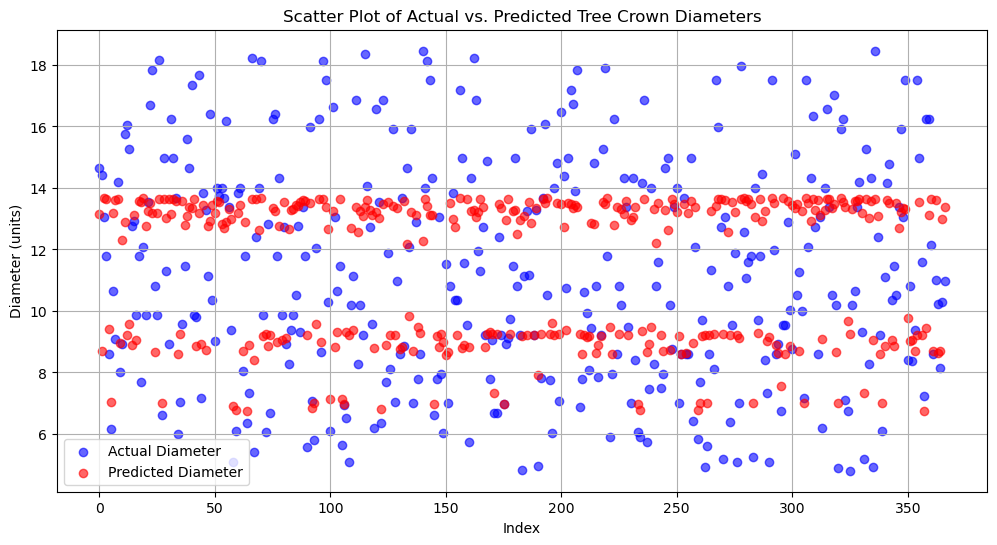

In [133]:
du.plot_results(y_test, y_pred_SVR)

In [134]:
du.compare(y_test, y_pred_SVR)

    Actual Diameter  Predicted Diameter  Difference (Absolute)
0         14.642221           13.148745               1.493476
1         14.419404            8.698146               5.721258
2         13.050675           13.659356               0.608681
3         11.777438           13.651884               1.874445
4          8.594347            9.426055               0.831708
5          6.174623            7.025305               0.850682
6         10.663356           13.192386               2.529030
7          9.103641           13.612984               4.509343
8         14.196588           13.638022               0.558566
9          8.021390            8.962592               0.941201
10         8.912656           12.307309               3.394653
11        15.756303           12.895685               2.860617
12        16.042781            9.234685               6.808095
13        15.278839            9.563680               5.715159
14        12.764197            8.894727               3

______ 
## Complex Neural Network 

In [135]:
CNN = du.CNN(X_train)
CNN.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100


/opt/homebrew/Caskroom/miniconda/base/envs/IRP_2/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 74.9701 - val_loss: 112.4229
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.1179 - val_loss: 99.1088
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.6927 - val_loss: 87.9140
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.6060 - val_loss: 78.0937
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.1638 - val_loss: 70.8211
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.9207 - val_loss: 53.2127
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.2617 - val_loss: 45.1561
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.0827 - val_loss: 32.4099
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.0828 - val_loss: 33.5839
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.4747 - val_loss: 22.5227
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.6777 - val_loss: 16.4955
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

In [136]:
y_pred_CNN = CNN.predict(X_test).flatten()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [137]:
du.mse_and_rmse(y_pred_CNN, y_test)

Mean Squared Error: 8.100086321228527
Root Mean Squared Error: 2.84606505920517


(8.100086321228527, 2.84606505920517)

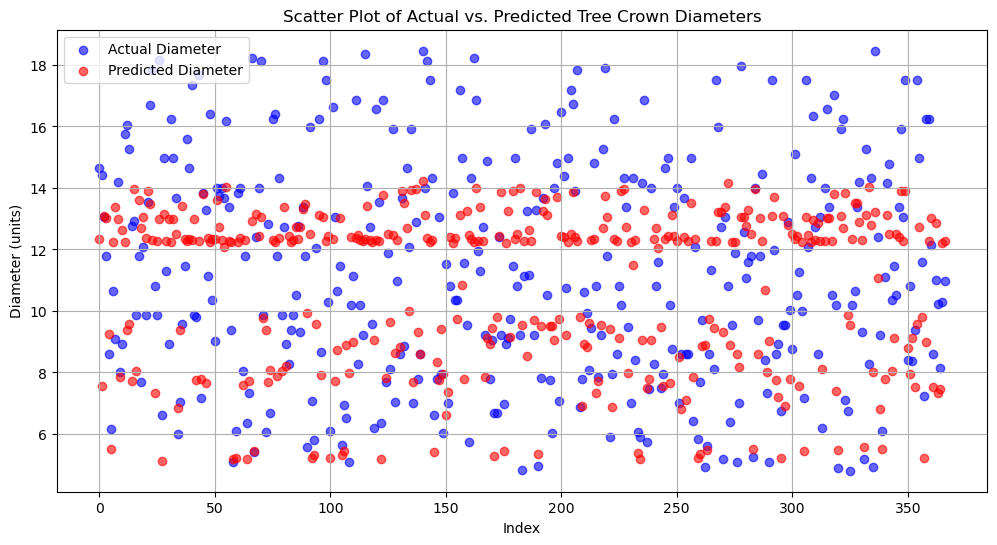

In [138]:
du.plot_results(y_test, y_pred_CNN)

In [139]:
du.compare(y_test, y_pred_CNN)

    Actual Diameter  Predicted Diameter  Difference (Absolute)
0         14.642221           12.327103               2.315118
1         14.419404            7.567991               6.851413
2         13.050675           13.075444               0.024769
3         11.777438           13.014607               1.237169
4          8.594347            9.240038               0.645691
5          6.174623            5.508148               0.666475
6         10.663356           12.242489               1.579133
7          9.103641           13.382925               4.279284
8         14.196588           12.989058               1.207529
9          8.021390            7.864925               0.156465
10         8.912656           12.625322               3.712666
11        15.756303           12.258767               3.497535
12        16.042781            9.390187               6.652593
13        15.278839            9.591734               5.687105
14        12.764197            7.738814               5

______ 
## XG Boost Model 

In [140]:
xg_model = du.xgboost(X_train, y_train, X_val, y_val)

[0]	validation_0-rmse:3.62956
[1]	validation_0-rmse:3.61340
[2]	validation_0-rmse:3.59685
[3]	validation_0-rmse:3.58111
[4]	validation_0-rmse:3.56575
[5]	validation_0-rmse:3.54974
[6]	validation_0-rmse:3.53432
[7]	validation_0-rmse:3.51858
[8]	validation_0-rmse:3.50888
[9]	validation_0-rmse:3.49982
[10]	validation_0-rmse:3.48532
[11]	validation_0-rmse:3.47077
[12]	validation_0-rmse:3.45643
[13]	validation_0-rmse:3.44285
[14]	validation_0-rmse:3.43192
[15]	validation_0-rmse:3.41832
[16]	validation_0-rmse:3.41024
[17]	validation_0-rmse:3.39833
[18]	validation_0-rmse:3.38519
[19]	validation_0-rmse:3.37396
[20]	validation_0-rmse:3.36198
[21]	validation_0-rmse:3.35495
[22]	validation_0-rmse:3.34256
[23]	validation_0-rmse:3.33153
[24]	validation_0-rmse:3.31998
[25]	validation_0-rmse:3.31153
[26]	validation_0-rmse:3.29939
[27]	validation_0-rmse:3.28815
[28]	validation_0-rmse:3.27800
[29]	validation_0-rmse:3.26720
[30]	validation_0-rmse:3.25701
[31]	validation_0-rmse:3.25013
[32]	validation_0-

In [141]:
y_pred_xg = xg_model.predict(X_test)

In [142]:
du.mse_and_rmse(y_test, y_pred_xg)

Mean Squared Error: 8.229392338486868
Root Mean Squared Error: 2.868691746857244


(8.229392338486868, 2.868691746857244)

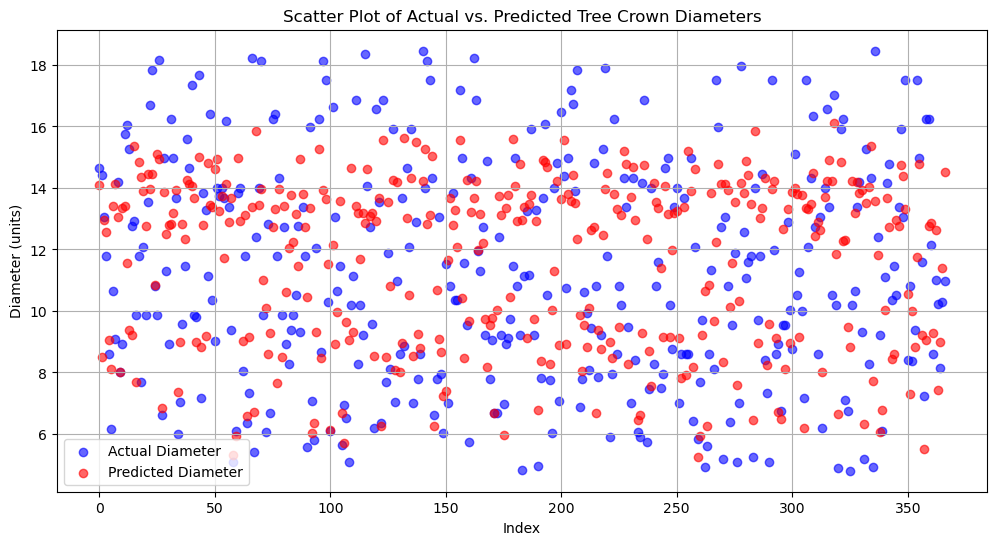

In [143]:
du.plot_results(y_test, y_pred_xg)

In [144]:
du.compare(y_test, y_pred_xg)

    Actual Diameter  Predicted Diameter  Difference (Absolute)
0         14.642221           14.085665               0.556556
1         14.419404            8.491069               5.928335
2         13.050675           12.950533               0.100142
3         11.777438           12.567360               0.789922
4          8.594347            9.060101               0.465754
5          6.174623            8.098030               1.923407
6         10.663356           13.401609               2.738253
7          9.103641           14.143422               5.039781
8         14.196588           13.050285               1.146302
9          8.021390            8.002659               0.018732
10         8.912656           13.341922               4.429266
11        15.756303           13.426268               2.330035
12        16.042781           11.569323               4.473458
13        15.278839            9.386046               5.892792
14        12.764197            9.226659               3

In [145]:
#save this model for use in other notebooks 
joblib.dump(xg_model, 'models/xgboost_model.pkl')

['models/xgboost_model.pkl']

## Best Model (XGBoost) on Test Set 

In [146]:
test_df = test_df[['xmin', 'ymin', 'xmax', 'ymax', 'name', 'diameter']]

In [147]:
test_df_encoded = du.prepare_data(test_df, 'diameter')

In [148]:
X_test_final = test_df_encoded[['bbox_area', 'bbox_diagonal', 'bbox_across', 
        'name_Cacao', 'name_Musacea', 'name_Guaba', 'name_Mango', 'name_Otra variedad']].values
y_test_final = test_df_encoded['diameter'].values

X_scaled_test_final = scaler.transform(X_test_final)

In [149]:
y_test_pred = xg_model.predict(X_scaled_test_final)

In [150]:
du.mse_and_rmse(y_test_final, y_test_pred)

Mean Squared Error: 8.493331574534364
Root Mean Squared Error: 2.914332097502679


(8.493331574534364, 2.914332097502679)

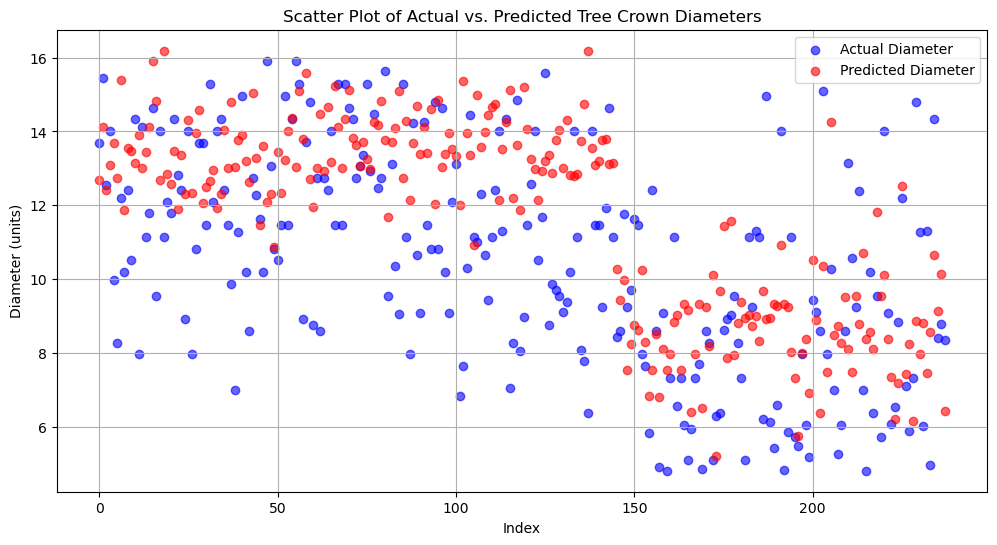

In [151]:
du.plot_results(y_test_final, y_test_pred)

In [152]:
du.compare(y_test_final, y_test_pred, head_or_tail='tail')

     Actual Diameter  Predicted Diameter  Difference (Absolute)
218         9.549274           11.805375               2.256101
219         5.729565            9.551380               3.821816
220        14.005602           10.121351               3.884251
221         9.071811            8.381227               0.690584
222         6.079705            7.335198               1.255494
223         6.531158            6.219589               0.311568
224         8.833925            7.181010               1.652914
225        12.191240           12.534988               0.343748
226         7.092868            7.423304               0.330436
227         5.869331            8.227768               2.358437
228         7.328027            6.157826               1.170200
229        14.801375            8.862679               5.938697
230        11.268144            7.967696               3.300448
231         6.016043            8.818188               2.802145
232        11.299975            7.456180